<a href="https://colab.research.google.com/github/ankersp/thesis/blob/main/Finetuning_of_ESGbert_ESG_and_ClimateBERT_environmental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers
!pip install accelerate
!pip install datasets

# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import datasets
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline # for using the models
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback # functions for the training


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# ESGBERT Environmental BERT

In [19]:
# Load the Environmental model
print("Loading Environmental model...")
env_model_name = "ESGBERT/EnvironmentalBERT-environmental"
env_tokenizer = AutoTokenizer.from_pretrained(env_model_name, max_len=512)
env_model = AutoModelForSequenceClassification.from_pretrained(env_model_name)
pipe_env = pipeline("text-classification", model=env_model, tokenizer=env_tokenizer, device=0)


Loading Environmental model...


tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Device set to use cuda:0


In [20]:
# Use the dataset from the paper that is available on HuggingFace
dataset_name = "ESGBERT/environmental_2k"
hf_dataset = datasets.load_dataset(dataset_name)
data = hf_dataset["train"].to_pandas()[["text", "env"]]

# traintest split using the non-preprocessed data (df)
# Use stratify to keep the label distribution of the original dataset
# Use random_state to always have the same outcome of the split
train, test = train_test_split(data, test_size=.2, stratify=data["env"], random_state=42)
train, val = train_test_split(train, test_size=.2, stratify=train["env"], random_state=42)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

environmental_2k.csv:   0%|          | 0.00/362k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

                                                   text  env
952   The Company's remuneration policy aims to link...    0
410   Local and responsible production – Buoyed by i...    1
1378  > Project started with peers in pharmaceutical...    0
21    One year ago, around 20 percent the portfolio ...    0
554   The Company also strives to maximize the benef...    1
Training data size: 1280


In [21]:
# costum Config
class Config:
  model = 'ESGBERT/EnvironmentalBERT-base' # the model we want to fine-tune
  tokenizer = 'ESGBERT/EnvironmentalBERT-base' # the used tokenizer that transforms text to machine-readable bits
  # define classification task
  task = "env" # take a look at the dataset (below): the column with the labels is called "env"
  steps = 20 # after how many steps of training do I want the model to be evaluated
  epochs = 5 # how often will the dataset run through the model
  batch_size = 16 # how many single datapoint (i.e. sentences)
  learning_rate = 5e-5 # how "fast" should the model learn the data

  gradient_accumulation = 2
  warmup_ratio = 0.1
  weight_decay = 0.1
  patience = 3
  device = 'cuda'

In [22]:
def finetuneModel(Config, train, val):
  # Tokenizer
  # preparing the inputs for a model
  tokenizer = AutoTokenizer.from_pretrained(Config.tokenizer)
  def tokenize(batch):
      tokens = tokenizer(batch['text'], truncation=True, max_length=512)
      tokens['labels'] = batch['labels']
      return tokens

  # Data Collator
  # helps to form a batch of dataset objects
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Fill in training arguments from Config
  training_args = TrainingArguments(
      output_dir="./",
      overwrite_output_dir = False,
      evaluation_strategy="steps",
      logging_strategy="steps",
      logging_steps=Config.steps,
      eval_steps=Config.steps,
      num_train_epochs=Config.epochs,
      per_device_train_batch_size=Config.batch_size,
      per_device_eval_batch_size=Config.batch_size,
      learning_rate=Config.learning_rate,
      weight_decay=Config.weight_decay,
      gradient_accumulation_steps=Config.gradient_accumulation,
      warmup_ratio=Config.warmup_ratio,
      metric_for_best_model='eval_f1', # eval_f1
      load_best_model_at_end=True,
      )

  # Evaluation metrics
  # we want accuracy, f1, precision and recall as our metrics for evaluation
  def compute_metrics(pred):
      labels = pred.label_ids
      preds = pred.predictions.argmax(-1)
      precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
      acc = accuracy_score(labels, preds)
      return {
          'accuracy': acc,
          'f1': f1,
          'precision': precision,
          'recall': recall
      }

  # model inititialisation
  # we use the base model of Environmental-BERT
  model = AutoModelForSequenceClassification.from_pretrained(Config.model, num_labels=2)

  # HuggingFace Dataset structure
  # create a datastructure that the HuggingFace model can read
  train_dict = {'text': train["text"], 'labels': train[Config.task]}
  val_dict = {'text': val["text"], 'labels': val[Config.task]}
  train_dataset = datasets.Dataset.from_dict(train_dict)
  val_dataset = datasets.Dataset.from_dict(val_dict)
  # tokenize
  train_dataset = train_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])
  val_dataset = val_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])

  # Trainer
  # object that combines all prior steps
  trainer = Trainer(
      model,
      training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=Config.patience)]
  )

  # start the model training
  trainer.train()

  # return the final model
  return model, tokenizer

In [23]:
# training
model, tokenizer = finetuneModel(Config, train, val)

tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ESGBERT/EnvironmentalBERT-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

<ipython-input-22-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.236700,0.478993,0.675000,0.412056,0.836991,0.504762
40,0.557900,0.199475,0.943750,0.937107,0.931592,0.943522
60,0.295500,0.171732,0.956250,0.950858,0.946867,0.955260
80,0.224600,0.215051,0.925000,0.917917,0.907305,0.934441
100,0.186200,0.244138,0.950000,0.942436,0.949861,0.935991
120,0.187300,0.208542,0.956250,0.950626,0.948532,0.952824


Could not locate the best model at ./checkpoint-60/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


In [18]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Device set to use cuda:0


Evaluation of ESGBERT/EnvironmentalBERT-base
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       268
           1       0.91      0.95      0.93       132

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.96      0.95      0.96       400

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/baseline_esgbert_env_metrics.csv


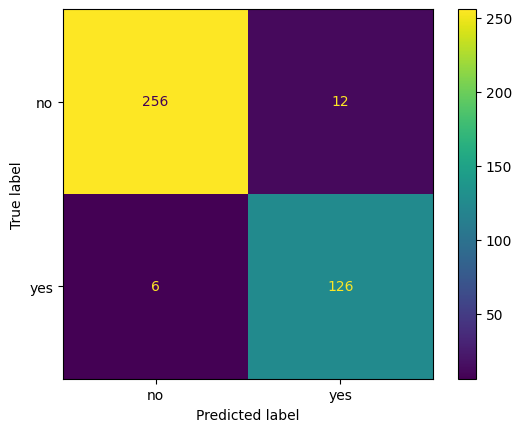

In [24]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
env_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, env_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/baseline_esgbert_env_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


## **Fine-tuning**

In [21]:
import pandas as pd

# Specify the path to the file in Google Drive
file_path = '/content/drive/My Drive/KU/kandidat/speciale/R/annotated_1000_train.csv'
annotated_data = pd.read_csv(file_path)

print(annotated_data.columns)


Index(['id', 'text', 'Env_label.1...label..0...none',
       'Soc_label..1...label..0...none', 'Gov_label.1...label..0...none',
       'Sentiment..1...positive..0...negative', 'Action..1...label..0...none',
       'Future..1...label..0...none', 'doc_id', 'CVR', 'Year'],
      dtype='object')


In [24]:
# Rename the column
annotated_data.rename(columns={"Env_label.1...label..0...none": "env"}, inplace=True)

# Validate renaming
print("Updated column names:", annotated_data.columns)

# Select relevant columns
annotated_data = annotated_data[["text", "env"]]

# Append to training data
train = pd.concat([train, annotated_data], ignore_index=True)

# Optional: Shuffle the combined dataset
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

Updated column names: Index(['text', 'env'], dtype='object')
                                                text  env
0  Each year, Vattenfall publishes a CSR report (...    0
1  Ethics and compliance The S&SC reviewed these ...    0
2  We have a robust approach to managing risk, wh...    0
3  Explore further: Become the best connected bre...    0
4  The policy is supplemented by a number of guid...    0
Training data size: 2080


In [25]:
# training
model, tokenizer = finetuneModel(Config, train, val)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ESGBERT/EnvironmentalBERT-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2080 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

<ipython-input-15-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.246800,0.506014,0.671875,0.401869,0.335938,0.500000
40,0.681400,0.325715,0.912500,0.898730,0.908095,0.891030
60,0.449500,0.171723,0.950000,0.943300,0.943300,0.943300
80,0.268000,0.193332,0.950000,0.943300,0.943300,0.943300
100,0.331000,0.161805,0.943750,0.937107,0.931592,0.943522
120,0.228500,0.200525,0.956250,0.951302,0.944081,0.960133
140,0.255100,0.172164,0.953125,0.946713,0.947828,0.945626
160,0.168700,0.187793,0.959375,0.954473,0.949567,0.960022
180,0.201800,0.199008,0.943750,0.936817,0.932954,0.941085
200,0.108200,0.210100,0.946875,0.940735,0.934409,0.948283


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Could not locate the best model at ./checkpoint-160/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of ESGBERT/EnvironmentalBERT-base
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       268
           1       0.94      0.91      0.92       132

    accuracy                           0.95       400
   macro avg       0.95      0.94      0.94       400
weighted avg       0.95      0.95      0.95       400

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_env_metrics.csv


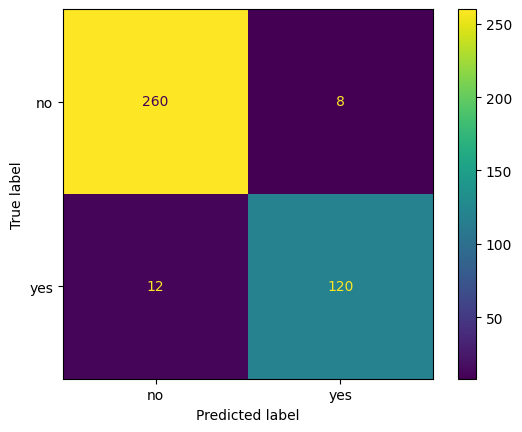

In [26]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
env_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, env_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_env_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


In [27]:
# Save model and tokenizer
model.save_pretrained("finetuned_esgbert_env_model")
tokenizer.save_pretrained("finetuned_esgbert_env_model")


('finetuned_esgbert_env_model/tokenizer_config.json',
 'finetuned_esgbert_env_model/special_tokens_map.json',
 'finetuned_esgbert_env_model/vocab.json',
 'finetuned_esgbert_env_model/merges.txt',
 'finetuned_esgbert_env_model/added_tokens.json',
 'finetuned_esgbert_env_model/tokenizer.json')

In [28]:
!mv /content/finetuned_esgbert_env_model /content/drive/My\ Drive/KU/kandidat/speciale/R/

# **ESGBERT Social bert**

In [56]:
# Load the social model
print("Loading social model...")
soc_model_name = "ESGBERT/SocialBERT-social"
soc_tokenizer = AutoTokenizer.from_pretrained(soc_model_name, max_len=512)
soc_model = AutoModelForSequenceClassification.from_pretrained(soc_model_name)
pipe_soc = pipeline("text-classification", model=soc_model, tokenizer=soc_tokenizer, device=0)



Loading social model...


Device set to use cuda:0


In [57]:
# Use the dataset from the paper that is available on HuggingFace
dataset_name = "ESGBERT/social_2k"
hf_dataset = datasets.load_dataset(dataset_name)
data = hf_dataset["train"].to_pandas()[["text", "soc"]]

# traintest split using the non-preprocessed data (df)
# Use stratify to keep the label distribution of the original dataset
# Use random_state to always have the same outcome of the split
train, test = train_test_split(data, test_size=.2, stratify=data["soc"], random_state=42)
train, val = train_test_split(train, test_size=.2, stratify=train["soc"], random_state=42)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

                                                   text  soc
1929  The majority of suppliers already had access t...    0
1099  Our approach to ESG and sustainability is fund...    1
6     Training The training delivered is designed to...    1
795   The Directors believe that the Company's succe...    1
1889  Our goal is for every employee to feel a stron...    1
Training data size: 1280


In [58]:
# costum Config
class Config:
  model = 'ESGBERT/SocialBERT-base' # the model we want to fine-tune
  tokenizer = 'ESGBERT/SocialBERT-base' # the used tokenizer that transforms text to machine-readable bits
  # define classification task
  task = "soc" # take a look at the dataset (below): the column with the labels is called "env"
  steps = 20 # after how many steps of training do I want the model to be evaluated
  epochs = 5 # how often will the dataset run through the model
  batch_size = 16 # how many single datapoint (i.e. sentences)
  learning_rate = 5e-5 # how "fast" should the model learn the data

  # not necessary to understand but google these concepts if you feel like it
  gradient_accumulation = 2
  warmup_ratio = 0.1
  weight_decay = 0.1
  patience = 3
  device = 'cuda'

In [59]:
def finetuneModel(Config, train, val):
  # Tokenizer
  # preparing the inputs for a model
  tokenizer = AutoTokenizer.from_pretrained(Config.tokenizer)
  def tokenize(batch):
      tokens = tokenizer(batch['text'], truncation=True, max_length=512)
      tokens['labels'] = batch['labels']
      return tokens

  # Data Collator
  # helps to form a batch of dataset objects
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Fill in training arguments from Config
  training_args = TrainingArguments(
      output_dir="./",
      overwrite_output_dir = False,
      evaluation_strategy="steps",
      logging_strategy="steps",
      logging_steps=Config.steps,
      eval_steps=Config.steps,
      num_train_epochs=Config.epochs,
      per_device_train_batch_size=Config.batch_size,
      per_device_eval_batch_size=Config.batch_size,
      learning_rate=Config.learning_rate,
      weight_decay=Config.weight_decay,
      gradient_accumulation_steps=Config.gradient_accumulation,
      warmup_ratio=Config.warmup_ratio,
      metric_for_best_model='eval_f1', # eval_f1
      load_best_model_at_end=True,
      )

  # Evaluation metrics
  # we want accuracy, f1, precision and recall as our metrics for evaluation
  def compute_metrics(pred):
      labels = pred.label_ids
      preds = pred.predictions.argmax(-1)
      precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
      acc = accuracy_score(labels, preds)
      return {
          'accuracy': acc,
          'f1': f1,
          'precision': precision,
          'recall': recall
      }

  # model inititialisation
  # we use the base model of Environmental-BERT
  model = AutoModelForSequenceClassification.from_pretrained(Config.model, num_labels=2)

  # HuggingFace Dataset structure
  # create a datastructure that the HuggingFace model can read
  train_dict = {'text': train["text"], 'labels': train[Config.task]}
  val_dict = {'text': val["text"], 'labels': val[Config.task]}
  train_dataset = datasets.Dataset.from_dict(train_dict)
  val_dataset = datasets.Dataset.from_dict(val_dict)
  # tokenize
  train_dataset = train_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])
  val_dataset = val_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])

  # Trainer
  # object that combines all prior steps
  trainer = Trainer(
      model,
      training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=Config.patience)]
  )

  # start the model training
  trainer.train()

  # return the final model
  return model, tokenizer

In [60]:
# training
model, tokenizer = finetuneModel(Config, train, val)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ESGBERT/SocialBERT-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

<ipython-input-59-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.365000,0.505369,0.837500,0.824849,0.844961,0.816064
40,0.764200,0.199275,0.915625,0.912656,0.911267,0.914221
60,0.339400,0.234258,0.900000,0.898247,0.895208,0.908681
80,0.352300,0.193183,0.909375,0.906819,0.903687,0.911502
100,0.164800,0.203183,0.915625,0.914073,0.910669,0.924287
120,0.221600,0.196065,0.921875,0.920438,0.916955,0.930780
140,0.061500,0.227344,0.931250,0.929530,0.925750,0.936118
160,0.104000,0.291304,0.928125,0.926399,0.922575,0.933500
180,0.044700,0.346001,0.915625,0.914073,0.910669,0.924287
200,0.032700,0.368194,0.906250,0.904762,0.902073,0.916433


Could not locate the best model at ./checkpoint-140/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of ESGBERT/SocialBERT-base
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       239
           1       0.88      0.98      0.92       161

    accuracy                           0.94       400
   macro avg       0.93      0.94      0.93       400
weighted avg       0.94      0.94      0.94       400

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/baseline_esgbert_soc_metrics.csv


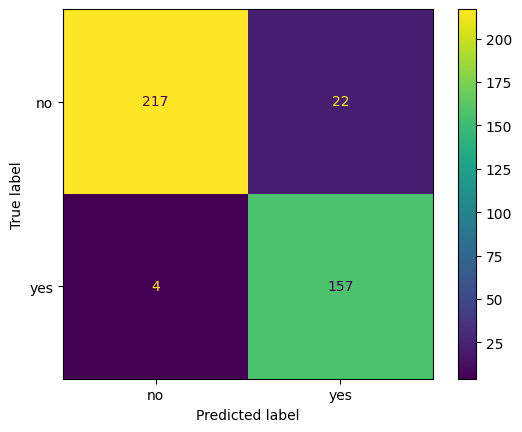

In [61]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
soc_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, soc_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/baseline_esgbert_soc_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


## **Finetuning**

In [62]:
import pandas as pd

# Specify the path to the file in Google Drive
file_path = '/content/drive/My Drive/KU/kandidat/speciale/R/annotated_1000_train.csv'
annotated_data = pd.read_csv(file_path)

print(annotated_data.columns)


Index(['id', 'text', 'Env_label.1...label..0...none',
       'Soc_label..1...label..0...none', 'Gov_label.1...label..0...none',
       'Sentiment..1...positive..0...negative', 'Action..1...label..0...none',
       'Future..1...label..0...none', 'doc_id', 'CVR', 'Year'],
      dtype='object')


In [63]:
# Rename the column
annotated_data.rename(columns={"Soc_label..1...label..0...none": "soc"}, inplace=True)

# Validate renaming
print("Updated column names:", annotated_data.columns)

# Select relevant columns
annotated_data = annotated_data[["text", "soc"]]

# Append to training data
train = pd.concat([train, annotated_data], ignore_index=True)

# Optional: Shuffle the combined dataset
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

Updated column names: Index(['id', 'text', 'Env_label.1...label..0...none', 'soc',
       'Gov_label.1...label..0...none',
       'Sentiment..1...positive..0...negative', 'Action..1...label..0...none',
       'Future..1...label..0...none', 'doc_id', 'CVR', 'Year'],
      dtype='object')
                                                text  soc
0  Each year, Vattenfall publishes a CSR report (...    1
1  The Company family holds 88.86% of L’Arche Gre...    0
2  These broadly align to the orderly 2°C scenari...    0
3  We aim to significantly improve our safety per...    1
4  The policy is supplemented by a number of guid...    0
Training data size: 2080


In [64]:
# training
model, tokenizer = finetuneModel(Config, train, val)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ESGBERT/SocialBERT-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2080 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

<ipython-input-59-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.320700,0.574269,0.596875,0.373777,0.298438,0.500000
40,1.084000,0.362596,0.821875,0.818902,0.817059,0.828138
60,0.670000,0.261667,0.887500,0.883112,0.883112,0.883112
80,0.571300,0.237172,0.890625,0.888214,0.884785,0.895795
100,0.381400,0.233983,0.915625,0.913057,0.910326,0.916738
120,0.480700,0.231377,0.906250,0.903904,0.900392,0.910142
140,0.446200,0.260228,0.903125,0.901171,0.897693,0.910041
160,0.248300,0.258319,0.915625,0.913599,0.909915,0.920512
180,0.283800,0.252345,0.909375,0.907547,0.903991,0.916535
200,0.210300,0.308795,0.893750,0.891888,0.888928,0.902188


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Could not locate the best model at ./checkpoint-220/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of ESGBERT/SocialBERT-base
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       239
           1       0.90      0.94      0.92       161

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_soc_metrics.csv


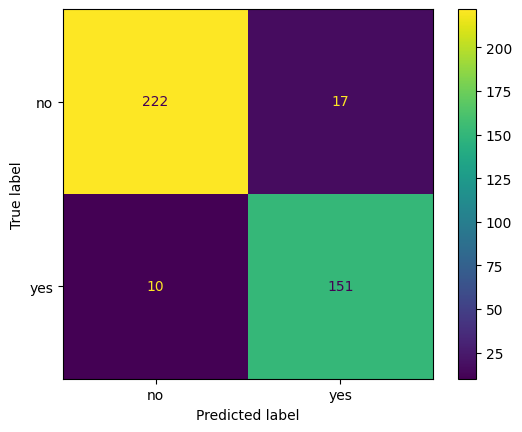

In [65]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
soc_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, soc_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_soc_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


In [66]:
# Save model and tokenizer
model.save_pretrained("finetuned_esgbert_soc_model")
tokenizer.save_pretrained("finetuned_esgbert_soc_model")


('finetuned_esgbert_soc_model/tokenizer_config.json',
 'finetuned_esgbert_soc_model/special_tokens_map.json',
 'finetuned_esgbert_soc_model/vocab.json',
 'finetuned_esgbert_soc_model/merges.txt',
 'finetuned_esgbert_soc_model/added_tokens.json',
 'finetuned_esgbert_soc_model/tokenizer.json')

In [67]:
!mv /content/finetuned_esgbert_soc_model /content/drive/My\ Drive/KU/kandidat/speciale/R/

# **ESGBERT Governance BERT**

In [68]:
# Load the governance model
print("Loading governance model...")
gov_model_name = "ESGBERT/GovernanceBERT-governance"
gov_tokenizer = AutoTokenizer.from_pretrained(gov_model_name, max_len=512)
gov_model = AutoModelForSequenceClassification.from_pretrained(gov_model_name)
pipe_gov = pipeline("text-classification", model=gov_model, tokenizer=gov_tokenizer, device=0)



Loading governance model...


Device set to use cuda:0


In [69]:
# Use the dataset from the paper that is available on HuggingFace
dataset_name = "ESGBERT/governance_2k"
hf_dataset = datasets.load_dataset(dataset_name)
data = hf_dataset["train"].to_pandas()[["text", "gov"]]

# traintest split using the non-preprocessed data (df)
# Use stratify to keep the label distribution of the original dataset
# Use random_state to always have the same outcome of the split
train, test = train_test_split(data, test_size=.2, stratify=data["gov"], random_state=42)
train, val = train_test_split(train, test_size=.2, stratify=train["gov"], random_state=42)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

                                                   text  gov
393   Consideration of individual performance The Co...    0
1375  The Company and its subsidiaries are also subj...    1
852   Compliance: The structure of the system and th...    1
868   We have a clear and transparent structure of g...    1
1420  We also conduct anti-bribery compliance audits...    1
Training data size: 1280


In [70]:
# costum Config
class Config:
  model = 'ESGBERT/GovernanceBERT-base' # the model we want to fine-tune
  tokenizer = 'ESGBERT/GovernanceBERT-base' # the used tokenizer that transforms text to machine-readable bits
  # define classification task
  task = "gov" # take a look at the dataset (below): the column with the labels is called "env"
  steps = 20 # after how many steps of training do I want the model to be evaluated
  epochs = 5 # how often will the dataset run through the model
  batch_size = 16 # how many single datapoint (i.e. sentences)
  learning_rate = 5e-5 # how "fast" should the model learn the data

  gradient_accumulation = 2
  warmup_ratio = 0.1
  weight_decay = 0.1
  patience = 3
  device = 'cuda'

In [71]:
def finetuneModel(Config, train, val):
  # Tokenizer
  # preparing the inputs for a model
  tokenizer = AutoTokenizer.from_pretrained(Config.tokenizer)
  def tokenize(batch):
      tokens = tokenizer(batch['text'], truncation=True, max_length=512)
      tokens['labels'] = batch['labels']
      return tokens

  # Data Collator
  # helps to form a batch of dataset objects
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Fill in training arguments from Config
  training_args = TrainingArguments(
      output_dir="./",
      overwrite_output_dir = False,
      evaluation_strategy="steps",
      logging_strategy="steps",
      logging_steps=Config.steps,
      eval_steps=Config.steps,
      num_train_epochs=Config.epochs,
      per_device_train_batch_size=Config.batch_size,
      per_device_eval_batch_size=Config.batch_size,
      learning_rate=Config.learning_rate,
      weight_decay=Config.weight_decay,
      gradient_accumulation_steps=Config.gradient_accumulation,
      warmup_ratio=Config.warmup_ratio,
      metric_for_best_model='eval_f1', # eval_f1
      load_best_model_at_end=True,
      )

  # Evaluation metrics
  # we want accuracy, f1, precision and recall as our metrics for evaluation
  def compute_metrics(pred):
      labels = pred.label_ids
      preds = pred.predictions.argmax(-1)
      precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
      acc = accuracy_score(labels, preds)
      return {
          'accuracy': acc,
          'f1': f1,
          'precision': precision,
          'recall': recall
      }

  # model inititialisation
  # we use the base model of Environmental-BERT
  model = AutoModelForSequenceClassification.from_pretrained(Config.model, num_labels=2)

  # HuggingFace Dataset structure
  # create a datastructure that the HuggingFace model can read
  train_dict = {'text': train["text"], 'labels': train[Config.task]}
  val_dict = {'text': val["text"], 'labels': val[Config.task]}
  train_dataset = datasets.Dataset.from_dict(train_dict)
  val_dataset = datasets.Dataset.from_dict(val_dict)
  # tokenize
  train_dataset = train_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])
  val_dataset = val_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])

  # Trainer
  # object that combines all prior steps
  trainer = Trainer(
      model,
      training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=Config.patience)]
  )

  # start the model training
  trainer.train()

  # return the final model
  return model, tokenizer

In [72]:
# training
model, tokenizer = finetuneModel(Config, train, val)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ESGBERT/GovernanceBERT-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

<ipython-input-71-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.244000,0.487644,0.731250,0.422383,0.365625,0.500000
40,0.773500,0.396263,0.825000,0.797459,0.782792,0.832538
60,0.587300,0.350572,0.821875,0.793289,0.778897,0.826724
80,0.565000,0.335300,0.856250,0.826775,0.813636,0.846551
100,0.364300,0.357014,0.865625,0.834375,0.825380,0.845607
120,0.372800,0.347669,0.856250,0.826775,0.813636,0.846551
140,0.274900,0.431435,0.831250,0.805720,0.790569,0.844166
160,0.199500,0.428496,0.878125,0.847714,0.842003,0.854154
180,0.167800,0.490734,0.856250,0.824561,0.813753,0.839197
200,0.089400,0.500621,0.859375,0.827815,0.817554,0.841334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Could not locate the best model at ./checkpoint-160/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of ESGBERT/GovernanceBERT-base
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       292
           1       0.72      0.75      0.73       108

    accuracy                           0.85       400
   macro avg       0.81      0.82      0.82       400
weighted avg       0.85      0.85      0.85       400

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/baseline_esgbert_gov_metrics.csv


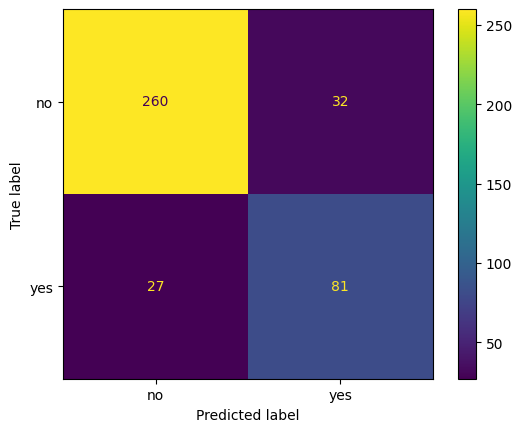

In [73]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
gov_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, gov_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/baseline_esgbert_gov_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


## Finetuning


In [74]:
import pandas as pd

# Specify the path to the file in Google Drive
file_path = '/content/drive/My Drive/KU/kandidat/speciale/R/annotated_1000_train.csv'
annotated_data = pd.read_csv(file_path)

print(annotated_data.columns)


Index(['id', 'text', 'Env_label.1...label..0...none',
       'Soc_label..1...label..0...none', 'Gov_label.1...label..0...none',
       'Sentiment..1...positive..0...negative', 'Action..1...label..0...none',
       'Future..1...label..0...none', 'doc_id', 'CVR', 'Year'],
      dtype='object')


In [75]:
# Rename the column
annotated_data.rename(columns={"Gov_label.1...label..0...none": "gov"}, inplace=True)

# Validate renaming
print("Updated column names:", annotated_data.columns)

# Select relevant columns
annotated_data = annotated_data[["text", "gov"]]

# Append to training data
train = pd.concat([train, annotated_data], ignore_index=True)

# Optional: Shuffle the combined dataset
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

Updated column names: Index(['id', 'text', 'Env_label.1...label..0...none',
       'Soc_label..1...label..0...none', 'gov',
       'Sentiment..1...positive..0...negative', 'Action..1...label..0...none',
       'Future..1...label..0...none', 'doc_id', 'CVR', 'Year'],
      dtype='object')
                                                text  gov
0  Each year, Vattenfall publishes a CSR report (...    1
1  To this end, the authorised intermediary and a...    0
2  The Company has a comprehensive health and saf...    0
3  Our board of directors has determined that the...    1
4  The policy is supplemented by a number of guid...    1
Training data size: 2080


In [76]:
# training
model, tokenizer = finetuneModel(Config, train, val)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ESGBERT/GovernanceBERT-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2080 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

<ipython-input-71-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.238600,0.534516,0.731250,0.422383,0.365625,0.500000
40,0.917700,0.401109,0.825000,0.792890,0.779350,0.817829
60,0.810700,0.449351,0.775000,0.750649,0.743861,0.802027
80,0.636600,0.369290,0.875000,0.843260,0.838647,0.848340
100,0.674800,0.453854,0.759375,0.738204,0.737486,0.798698
120,0.580000,0.463419,0.809375,0.784355,0.771795,0.829209
140,0.548500,0.425432,0.831250,0.807692,0.792846,0.851521


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Could not locate the best model at ./checkpoint-80/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of ESGBERT/GovernanceBERT-base
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       292
           1       0.67      0.84      0.75       108

    accuracy                           0.84       400
   macro avg       0.80      0.84      0.82       400
weighted avg       0.86      0.84      0.85       400

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_gov_metrics.csv


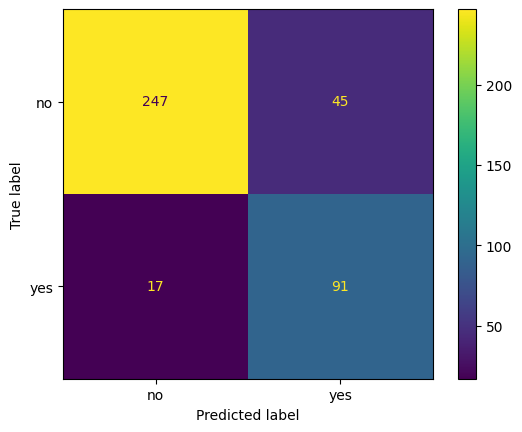

In [77]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
gov_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, gov_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_esgbert_gov_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


In [78]:
# Save model and tokenizer
model.save_pretrained("finetuned_esgbert_gov_model")
tokenizer.save_pretrained("finetuned_esgbert_gov_model")


('finetuned_esgbert_gov_model/tokenizer_config.json',
 'finetuned_esgbert_gov_model/special_tokens_map.json',
 'finetuned_esgbert_gov_model/vocab.json',
 'finetuned_esgbert_gov_model/merges.txt',
 'finetuned_esgbert_gov_model/added_tokens.json',
 'finetuned_esgbert_gov_model/tokenizer.json')

In [84]:
!mv '/content/finetuned_esgbert_gov_model' '/content/drive/My Drive/KU/kandidat/speciale/R/'

# ClimateBERT environmental claims

In [4]:
# Load Environmental model
print("Loading Environmental model...")
env_model_name = "climatebert/environmental-claims"
env_tokenizer = AutoTokenizer.from_pretrained(env_model_name, max_len=512)
env_model = AutoModelForSequenceClassification.from_pretrained(env_model_name)
pipe_env = pipeline("text-classification", model=env_model, tokenizer=env_tokenizer, device=0)


Loading Environmental model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/854 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Device set to use cuda:0


In [6]:
# Use the dataset from the paper that is available on HuggingFace
dataset_name = "climatebert/environmental_claims"
hf_dataset = datasets.load_dataset(dataset_name)
data = hf_dataset["train"].to_pandas()[["text", "label"]]

# traintest split using the non-preprocessed data (df)
# Use stratify to keep the label distribution of the original dataset
# Use random_state to always have the same outcome of the split
train, test = train_test_split(data, test_size=.2, stratify=data["label"], random_state=42)
train, val = train_test_split(train, test_size=.2, stratify=train["label"], random_state=42)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

                                                   text  label
775   Sustainable development Safety ■■ Environmenta...      1
623   To realize the non-carbon society aimed for un...      1
708   The reality is, I have about 18,000 tons of ca...      0
1859  They're at a lower tax rate and have helped th...      0
547   From an environmental perspective, the lockdow...      1
Training data size: 1354


In [7]:
# costum Config
class Config:
  model = 'climatebert/distilroberta-base-climate-f' # the model we want to fine-tune
  tokenizer = 'climatebert/distilroberta-base-climate-f' # the used tokenizer that transforms text to machine-readable bits
  # define classification task
  task = "label" # take a look at the dataset (below): the column with the labels is called "env"
  steps = 20 # after how many steps of training do I want the model to be evaluated
  epochs = 5 # how often will the dataset run through the model
  batch_size = 16 # how many single datapoint (i.e. sentences)
  learning_rate = 5e-5 # how "fast" should the model learn the data

  gradient_accumulation = 2
  warmup_ratio = 0.1
  weight_decay = 0.1
  patience = 3
  device = 'cuda'

In [8]:
def finetuneModel(Config, train, val):
  # Tokenizer
  # preparing the inputs for a model
  tokenizer = AutoTokenizer.from_pretrained(Config.tokenizer)
  def tokenize(batch):
      tokens = tokenizer(batch['text'], truncation=True, max_length=512)
      tokens['labels'] = batch['labels']
      return tokens

  # Data Collator
  # helps to form a batch of dataset objects
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Fill in training arguments from Config
  training_args = TrainingArguments(
      output_dir="./",
      overwrite_output_dir = False,
      evaluation_strategy="steps",
      logging_strategy="steps",
      logging_steps=Config.steps,
      eval_steps=Config.steps,
      num_train_epochs=Config.epochs,
      per_device_train_batch_size=Config.batch_size,
      per_device_eval_batch_size=Config.batch_size,
      learning_rate=Config.learning_rate,
      weight_decay=Config.weight_decay,
      gradient_accumulation_steps=Config.gradient_accumulation,
      warmup_ratio=Config.warmup_ratio,
      metric_for_best_model='eval_f1', # eval_f1
      load_best_model_at_end=True,
      )

  # Evaluation metrics
  # we want accuracy, f1, precision and recall as our metrics for evaluation
  def compute_metrics(pred):
      labels = pred.label_ids
      preds = pred.predictions.argmax(-1)
      precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
      acc = accuracy_score(labels, preds)
      return {
          'accuracy': acc,
          'f1': f1,
          'precision': precision,
          'recall': recall
      }

  # model inititialisation
  # we use the base model of Environmental-BERT
  model = AutoModelForSequenceClassification.from_pretrained(Config.model, num_labels=2)

  # HuggingFace Dataset structure
  # create a datastructure that the HuggingFace model can read
  train_dict = {'text': train["text"], 'labels': train[Config.task]}
  val_dict = {'text': val["text"], 'labels': val[Config.task]}
  train_dataset = datasets.Dataset.from_dict(train_dict)
  val_dataset = datasets.Dataset.from_dict(val_dict)
  # tokenize
  train_dataset = train_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])
  val_dataset = val_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])

  # Trainer
  # object that combines all prior steps
  trainer = Trainer(
      model,
      training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=Config.patience)]
  )

  # start the model training
  trainer.train()

  # return the final model
  return model, tokenizer

In [9]:
# training
model, tokenizer = finetuneModel(Config, train, val)

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1354 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

<ipython-input-8-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.275300,0.519649,0.749263,0.428331,0.374631,0.500000
40,0.822600,0.370700,0.814159,0.792290,0.783066,0.868157
60,0.417900,0.333164,0.849558,0.824543,0.805723,0.880037
80,0.434900,0.299935,0.887906,0.843208,0.863966,0.827351
100,0.284000,0.341562,0.899705,0.873196,0.857955,0.893932
120,0.190000,0.398066,0.893805,0.860837,0.855640,0.866512
140,0.172900,0.392713,0.896755,0.866200,0.857529,0.876308
160,0.092500,0.453002,0.884956,0.856948,0.839300,0.884090


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Could not locate the best model at ./checkpoint-100/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


In [10]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Device set to use cuda:0


Evaluation of climatebert/distilroberta-base-climate-f
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       317
           1       0.79      0.87      0.83       107

    accuracy                           0.91       424
   macro avg       0.87      0.90      0.88       424
weighted avg       0.91      0.91      0.91       424

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/baseline_climatebert_env_metrics.csv


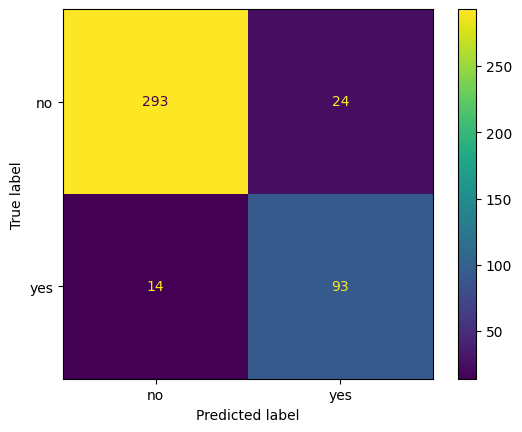

In [12]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
env_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, env_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/baseline_climatebert_env_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


## **Fine-tuning**

In [13]:
import pandas as pd

# Specify the path to the file in Google Drive
file_path = '/content/drive/My Drive/KU/kandidat/speciale/R/annotated_1000_train.csv'
annotated_data = pd.read_csv(file_path)

print(annotated_data.columns)


Index(['id', 'text', 'Env_label.1...label..0...none',
       'Soc_label..1...label..0...none', 'Gov_label.1...label..0...none',
       'Sentiment..1...positive..0...negative', 'Action..1...label..0...none',
       'Future..1...label..0...none', 'doc_id', 'CVR', 'Year'],
      dtype='object')


In [14]:
# Rename the column
annotated_data.rename(columns={"Env_label.1...label..0...none": "label"}, inplace=True)

# Validate renaming
print("Updated column names:", annotated_data.columns)

# Select relevant columns
annotated_data = annotated_data[["text", "label"]]

# Append to training data
train = pd.concat([train, annotated_data], ignore_index=True)

# Optional: Shuffle the combined dataset
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the updated training data
print(train.head())
print(f"Training data size: {len(train)}")

Updated column names: Index(['id', 'text', 'label', 'Soc_label..1...label..0...none',
       'Gov_label.1...label..0...none',
       'Sentiment..1...positive..0...negative', 'Action..1...label..0...none',
       'Future..1...label..0...none', 'doc_id', 'CVR', 'Year'],
      dtype='object')
                                                text  label
0  Policies for individual areas Environment and ...      1
1  However, historically, the Group's companies h...      0
2  So we're certainly on our way to our goal of 2...      0
3  The strategy reflects the Fund’s ambitions to ...      1
4  All group enterprises are required to comply w...      0
Training data size: 2154


In [15]:
# training
model, tokenizer = finetuneModel(Config, train, val)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2154 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

<ipython-input-8-96a2a190f89a>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,1.367700,0.568955,0.749263,0.428331,0.374631,0.500000
40,1.028900,0.344106,0.840708,0.784615,0.789477,0.780199
60,0.637200,0.296871,0.852507,0.821654,0.803097,0.858522
80,0.442800,0.459728,0.808260,0.783812,0.773151,0.852478
100,0.383000,0.412558,0.843658,0.819509,0.801969,0.880014
120,0.337700,0.388674,0.896755,0.874025,0.852719,0.911533
140,0.345000,0.363459,0.890855,0.867630,0.846130,0.907596
160,0.246200,0.633771,0.849558,0.827174,0.809563,0.891779
180,0.241000,0.430343,0.890855,0.865154,0.846040,0.895855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Could not locate the best model at ./checkpoint-120/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Device set to use cuda:0


Evaluation of climatebert/distilroberta-base-climate-f
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       317
           1       0.80      0.88      0.84       107

    accuracy                           0.91       424
   macro avg       0.88      0.90      0.89       424
weighted avg       0.92      0.91      0.91       424

Metrics saved to: /content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_env_metrics.csv


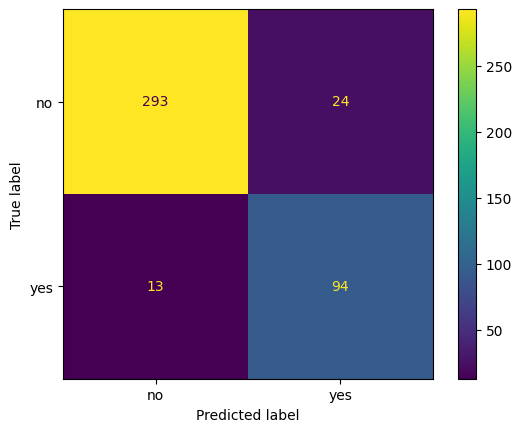

In [16]:
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a pipeline
env_pipe = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU if available; set to -1 for CPU
)

# Prepare test data
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Map model outputs to numerical labels
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Use transformer for predictions
def useTransformer(arr, classifier):
    arr_2 = classifier([x for x in arr])  # Classify each text
    res = [label_to_num(x['label']) for x in arr_2]
    return res

# Evaluate predictions, display metrics, and save them
def evaluate_and_save(labels, pred, name, save_path):
    print("Evaluation of " + name)

    # Generate classification report
    report_dict = classification_report(labels, pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # Display metrics
    print(classification_report(labels, pred))

    # Save metrics to Google Drive
    report_df.to_csv(save_path)
    print(f"Metrics saved to: {save_path}")

    # Display confusion matrix
    confMat = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
    disp.plot()
    plt.show()

# Predict
pred = useTransformer(text, env_pipe)

# Save metrics to Google Drive
metrics_save_path = "/content/drive/My Drive/KU/kandidat/speciale/R/finetuned_climatebert_env_metrics.csv"
evaluate_and_save(labels, pred, Config.model, metrics_save_path)


In [17]:
# Save model and tokenizer
model.save_pretrained("finetuned_climatebert_env_model")
tokenizer.save_pretrained("finetuned_climatebert_env_model")


('finetuned_climatebert_env_model/tokenizer_config.json',
 'finetuned_climatebert_env_model/special_tokens_map.json',
 'finetuned_climatebert_env_model/vocab.json',
 'finetuned_climatebert_env_model/merges.txt',
 'finetuned_climatebert_env_model/added_tokens.json',
 'finetuned_climatebert_env_model/tokenizer.json')

In [18]:
!mv /content/finetuned_climatebert_env_model /content/drive/My\ Drive/KU/kandidat/speciale/R/